# DeepASM
## Import packages

In [19]:
import sys

# Python packages for data, stats, and visualization
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns 

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.models import load_model
from tensorflow.keras import layers
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Kernel functions
from sklearn.neighbors import KernelDensity
from numpy import asarray
from matplotlib import pyplot
from numpy import exp

# Dimensionality reduction
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding

# To get the time
from datetime import datetime

 
# Figure parameters
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [20]:
# Print different versions
print(sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
TensorFlow version: 2.7.0
Keras version: 2.7.0
Numpy version: 1.19.5
Num GPUs Available:  1


## GCP Variables

In [91]:
# Import raw data from bucket. False if you want to import the processed dataset
IMPORT_RAW_FROM_BUCKET = True

# Export data after it's been prepared
EXPORT_PROCESSED_DATA = False

# Bucket name where the training datasets are
DEEPASM_BUCKET="deepasm"

# GCP variable
import os
projectid = 'hackensack-tyco'
os.environ["GOOGLE_CLOUD_PROJECT"] = 'hackensack-tyco'
cloud_bucket = "gs://deepasm/colab"


## Model variables

In [92]:
# MODELS FOR WHICH WE NEED TO RECORD THE RESULTS

models = ['linear', 'perceptron', 'simple_cnn',  'cnn', 'simple_rnn', 'rnn']
#models = ['simple_rnn']

# Loss is better than AUC for monitoring
PARAM_TO_CHANGE = "keep_chr"

#--------------------------------------------------
# Parameters common to all models

# Number of rows to take into the dataset after import
NB_ROWS_RAW_DATASET = int(0.2e6) # The maximum is 5e6. We use 200k to test the code

# Minimum correlation factor
MIN_CORR = 0.03

# Size of the genomic window
GENOMIC_INTERVAL = 1000

# Kernel values for probability estimates
KERNEL_FM_NB_VALUES = 10
KERNEL_FM_BANDWIDTH = 0.1
KERNEL_COV_NB_MAX = 200
KERNEL_COV_NB_STEP = 40
KERNEL_COV_BANDWIDTH = 20

# Normalization method
norm_method = "z_score" # "min_max" or "z_score"

# Keep the chromosomes in the model (correlate poorly with ASM)
KEEP_CHR_IN_MODEL = False

# Early stopping
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

# Percentage of data points to be used in the Test dataset
TEST_SPLIT = 0.2

# Percentage of datapoints used between training and validation
VALIDATION_SPLIT = 0.3 # How to divide the training dataset for validation

EPOCHS = 100 # We have so many datapoints that 20 epochs are enough to stabilize the training
BATCH_SIZE = 1000 # to get a few identified ASM we need at a few hundreds since the
# frequency of ASM is 1.38%
# A batch size of 1000 will run into a memory error on TF 2.7

# Regularlization L1 and L2 (defaults are l1 = 0.01 and l2 = 0.01)
L1_R = 0
L2_R = 1e-3

#--------------------------------------------------
# Parameters common to neural network models
ACTIVATION_FUNCTION = 'relu' # 'tanh' # or 'relu' or 'gelu (Gaussian Error Linear Unit)'
NB_NODES_PERCEPTRON = 10
NB_LAYERS_PERCEPTRON = 5
NB_NODES_AFTER_CNN = 2
CNN_FILTERS = 8
CNN_KERNEL = 100 # Must be smaller than the genomic region (250). The av distance between CpG is 37 bp and the std dev of the distances between cpgs is 24 bp
LEARNING_RATE = 3e-4 

# Learning rate was taken from this
# http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

#--------------------------------------------------
# Parameters common to RNN

RNN_UNITS = 64 # 64 orginally

#--------------------------------------------------
# SPECIFIC TO RANDOM FOREST ALGORITHM
use_raw_df_for_forest_models = False

## ML evaluation metrics

In [25]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='sensitivity'),
      keras.metrics.AUC(name='auc')
      ]

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'sensitivity']
  plt.figure(figsize=(10,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0,1])

    plt.legend()


def display_results(df_results):
  print("Loss", np.round(df_results[0], 3))
  print("True positives", np.round(df_results[1], 3))
  print("False positives", np.round(df_results[2], 3))
  print("True negatives", np.round(df_results[3], 3))
  print("False negatives", np.round(df_results[4], 3))
  print("Accuracy", np.round(df_results[5], 3))
  print("Precision", np.round(df_results[6], 3))
  print("Sensitivity", np.round(df_results[7], 3))
  print("AUC", np.round(df_results[8], 3))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,80])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')



2022-03-08 03:09:04.493537: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 03:09:06.651648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38444 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Import raw data

In [26]:
if IMPORT_RAW_FROM_BUCKET == True:
    !gsutil ls gs://$DEEPASM_BUCKET/$GENOMIC_INTERVAL*bp/encode_training_data/*.json > list_to_download.txt
    files_to_download_df = pd.read_csv('list_to_download.txt', header=None)

    imported_df = pd.DataFrame()

    for index_file in range(files_to_download_df.shape[0]):
        file_name_bucket = files_to_download_df[0][index_file]
        local_file_name = "training_" + str(index_file) + ".json"
        
        # Download the file from bucket
        !gsutil cp $file_name_bucket $local_file_name
        
        print("Appending file...")
        imported_df = imported_df.append(pd.read_json(local_file_name, lines = True))

Copying gs://deepasm/1000bp/encode_training_data/encode_training-000000000000.json...
- [1 files][257.9 MiB/257.9 MiB]                                                
Operation completed over 1 objects/257.9 MiB.                                    
Appending file...
Copying gs://deepasm/1000bp/encode_training_data/encode_training-000000000001.json...
/ [1 files][258.0 MiB/258.0 MiB]                                                
Operation completed over 1 objects/258.0 MiB.                                    
Appending file...
Copying gs://deepasm/1000bp/encode_training_data/encode_training-000000000002.json...
- [1 files][257.3 MiB/257.3 MiB]                                                
Operation completed over 1 objects/257.3 MiB.                                    
Appending file...
Copying gs://deepasm/1000bp/encode_training_data/encode_training-000000000003.json...
- [1 files][258.0 MiB/258.0 MiB]                                                
Operation completed over 1 objec

In [28]:
print("Size of the imported dataset:", imported_df.shape)

Size of the imported dataset: (4509754, 23)


## Prepare the features

Note: we do not randomize the rows because the scripts preceding this notebook already sampled the rows.

### Copy & clean dataframe 

In [47]:
# Copy of the dataframe
raw_df = imported_df.copy()
raw_df = raw_df.head(NB_ROWS_RAW_DATASET)

# We drop columns that are not going to be features
raw_df.drop('sample', axis = 1, inplace = True)
raw_df.drop('snp_id', axis = 1, inplace = True)
raw_df.drop('snp_pos', axis = 1, inplace = True)
raw_df.drop('wilcoxon_corr_pvalue', axis = 1, inplace = True)
raw_df.drop('asm_region_effect', axis = 1, inplace = True)

# We remove the chromosomes X and Y (no ASM)
raw_df = raw_df.loc[raw_df['chr'] != 'X']
raw_df = raw_df.loc[raw_df['chr'] != 'Y']

In [49]:
print("Size of the dataset: ", raw_df.shape)

Size of the dataset:  (197237, 18)


### Calculate the distance between CpGs

In [52]:
# Create a function to calculate the distance between CpGs (~3min)
def dist_cpg(cpg_pos):
  distances = []
  for index in range(len(cpg_pos)):
    if index >= len(cpg_pos)-1:
      return distances
    else:
      distances.append(cpg_pos[index + 1] - cpg_pos[index])
  return distances

# Apply the function "distance" to the array of CpG positions
raw_df['cpg_dist'] = raw_df['cpg_pos'].apply(lambda x: dist_cpg(x))

In [53]:
raw_df

,asm_snp,sample_category,chr,region_inf,region_sup,region_nb_cpg,nb_cpg_found,nb_reads,dnase,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,tot_nb_reads,read_fm,cpg_fm,cpg_cov,cpg_pos,cpg_dist
0,0,1,1,119313001,119314000,8,6,141,0,0,0,0.632,24030712,420944333,"[0, 0, 1, 0.5, 0.667, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0.463, 0.981, 1, 0.796, 0.927, 0.943000000000...","[54, 53, 58, 54, 55, 53]","[119313416, 119313421, 119313464, 119313512, 1...","[5, 43, 48, 2, 448]"
1,0,1,1,211213001,211214000,16,14,182,0,0,0,0.632,24030712,420944333,"[1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0...","[0.182, 0.2, 0.23800000000000002, 0.2380000000...","[22, 10, 21, 21, 19, 21, 15, 14, 23, 10, 34, 1...","[211213024, 211213259, 211213269, 211213313, 2...","[235, 10, 44, 14, 31, 35, 8, 4, 44, 106, 58, 1..."
2,0,1,4,17661001,17662000,16,15,181,2,0,1,0.632,24030712,420944333,"[1, 0, 0, 0, 1, 1, 1, 1, 0.75, 1, 1, 0.667, 1,...","[0.857, 0.794, 0.967, 0.862, 0.677, 0.903, 0.9...","[28, 34, 61, 29, 31, 31, 32, 31, 33, 44, 40, 4...","[17661167, 17661172, 17661178, 17661234, 17661...","[5, 6, 56, 20, 4, 70, 32, 28, 239, 146, 6, 34,..."
3,0,1,5,55314001,55315000,11,11,141,1,0,2,0.632,24030712,420944333,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0.444, 0.975, 0.97, 0.714, 1, 1, 1, 0.976, 0....","[27, 40, 33, 28, 31, 38, 38, 41, 29, 33, 65]","[55314039, 55314070, 55314084, 55314091, 55314...","[31, 14, 7, 4, 43, 2, 4, 4, 412, 195]"
4,0,1,1,81647001,81648000,8,8,209,1,0,0,0.632,24030712,420944333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.667, 0, 1, 0.25,...","[0.191, 0.13, 0.396, 0.396, 0.341, 0.245, 0.42...","[47, 46, 48, 48, 44, 53, 63, 36]","[81647176, 81647266, 81647334, 81647369, 81647...","[90, 68, 35, 8, 153, 78, 208]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,1,20,24299001,24300000,17,16,95,3,1,12,0.647,25049829,535812384,"[0, 0, 0.5, 0.5, 0.14300000000000002, 0, 0, 0....","[0.222, 0.467, 0.063, 0.08700000000000001, 0, ...","[27, 15, 16, 23, 30, 28, 27, 13, 19, 24, 26, 1...","[24299132, 24299154, 24299221, 24299227, 24299...","[22, 67, 6, 8, 55, 15, 25, 92, 6, 30, 15, 178,..."
199996,0,1,9,134148001,134149000,28,28,202,3,6,8,0.646,22540136,527040401,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0.917, 0.9570000000000001, 0.9570000000000...","[36, 12, 47, 23, 30, 14, 62, 60, 31, 40, 35, 3...","[134148115, 134148133, 134148135, 134148146, 1...","[18, 2, 11, 40, 38, 18, 55, 121, 47, 23, 40, 1..."
199997,0,1,11,50708001,50709000,11,9,266,0,0,5,0.646,22540136,527040401,"[0, 1, 0, 1, 0, 0, 0.333, 0, 0, 0.5, 0, 0, 0, ...","[0.86, 0.015, 0.016, 0, 0.022, 0.5660000000000...","[50, 65, 63, 48, 46, 53, 55, 43, 47]","[50708082, 50708248, 50708388, 50708405, 50708...","[166, 140, 17, 47, 173, 64, 213, 26]"
199998,0,1,17,74537001,74538000,23,21,130,1,9,20,0.646,22540136,527040401,"[1, 1, 0, 0.333, 0, 0, 0.5, 0.333, 0, 1, 1, 0....","[0, 0.13, 0.87, 0.973, 0, 0.043000000000000003...","[20, 23, 23, 37, 17, 23, 23, 11, 23, 34, 20, 3...","[74537027, 74537068, 74537092, 74537147, 74537...","[41, 24, 55, 9, 112, 4, 12, 93, 63, 22, 44, 81..."


### Convert arrays into numerical features

To do this, we use kernel estimates as well as simpler metrics like mean and standard deviation

#### Kernel functions

In [58]:
# FRACTIONAL METHYLATION

# Values for fractional methylation (between 0 and 1)
values_for_kernel_fm = asarray([value for value in range(0, KERNEL_FM_NB_VALUES+1)])
values_for_kernel_fm = values_for_kernel_fm / KERNEL_FM_NB_VALUES
print("X-axis values used for the FM kernel estimate:", values_for_kernel_fm)
values_for_kernel_fm = values_for_kernel_fm.reshape((len(values_for_kernel_fm), 1))

# Build Kernel model
kernel_fm_model = KernelDensity(bandwidth=KERNEL_FM_BANDWIDTH, kernel='gaussian')

# Function to be applied to each array in the columns read_fm and cpg_fm
def estimate_kernels_fm(x):
  sample = np.reshape(x, (len(x), 1))
  kernel_fm_model.fit(sample)
  probabilities = kernel_fm_model.score_samples(values_for_kernel_fm)
  probabilities = exp(probabilities)
  return np.round(probabilities, 4)

# Try function
estimate_kernels_fm(raw_df['read_fm'][1])


X-axis values used for the FM kernel estimate: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


array([2.9267, 1.8709, 0.5784, 0.2146, 0.2302, 0.2894, 0.2103, 0.1486,
       0.1677, 0.3284, 0.4871])

In [59]:
# COVERAGE AND CPG DISTANCE

# Values for fractional methylation (between 0 and 1)
values_for_kernel_cov = asarray([value for value in range(0, KERNEL_COV_NB_MAX, KERNEL_COV_NB_STEP)])
print("Values used in kernel estimate:", values_for_kernel_cov)
values_for_kernel_cov = values_for_kernel_cov.reshape((len(values_for_kernel_cov), 1))

# Build Kernel model
kernel_cov_model = KernelDensity(bandwidth=KERNEL_COV_BANDWIDTH, kernel='gaussian')

# Function to be applied to each array in the columns read_fm and cpg_fm
def estimate_kernels_cov(x):
  sample = np.reshape(x, (len(x), 1))
  kernel_fm_model.fit(sample)
  probabilities = kernel_fm_model.score_samples(values_for_kernel_cov)
  probabilities = exp(probabilities)
  return np.round(probabilities, 4)

# Try function
estimate_kernels_cov(raw_df['cpg_cov'][1])

Values used in kernel estimate: [  0  40  80 120 160]


array([0., 0., 0., 0., 0.])

#### Test kernel estimates

In [60]:
variable_to_plot = 'cpg_fm' # cpg_fm or read_fm or cpg_dist or cpg_cov

n_extract = 10
extract_asm = raw_df[raw_df['asm_snp'] == 1].sample(n=n_extract, ignore_index = True)
extract_noasm = raw_df[raw_df['asm_snp'] == 0].sample(n=n_extract, ignore_index = True)
n_x = round(np.sqrt(n_extract))

##### Plots for regions with ASM

Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates
Using the FM kernel estimates


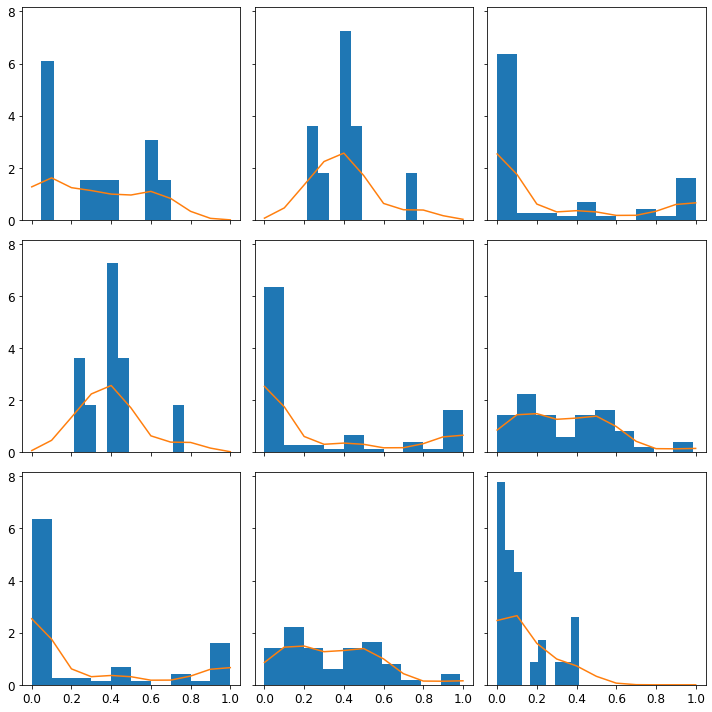

In [63]:
mpl.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(n_x, n_x, sharey=True, sharex=True, tight_layout=True)

for k in range(n_x):
  for m in range(n_x):

    # Print data distribution
    data_distribution = extract_asm[variable_to_plot][k+m]
    axs[k,m].hist(data_distribution, density = True, bins = 10)

    # Print kernel density
    if 'fm' in variable_to_plot:
        #print("Using the FM kernel estimates")
        kernel_probabilities = estimate_kernels_fm(data_distribution)
        values = values_for_kernel_fm
    else:
        #print("Using the COV kernel estimates")
        kernel_probabilities = estimate_kernels_cov(data_distribution)
        values = values_for_kernel_cov
    axs[k,m].plot(values[:], kernel_probabilities)


##### Plots for regions without ASM

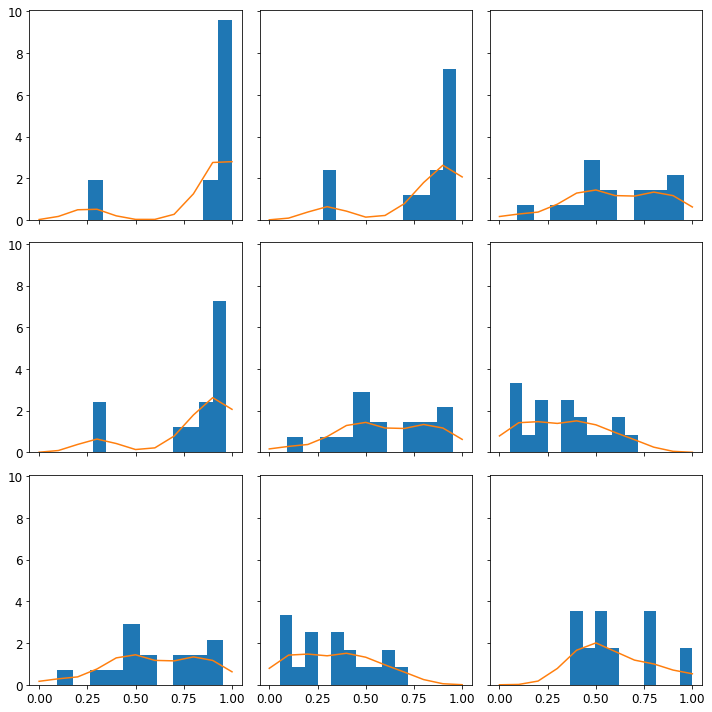

In [65]:
mpl.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(n_x, n_x, sharey=True, sharex=True, tight_layout=True)

for k in range(n_x):
  for m in range(n_x):

    # Print data distribution
    data_distribution = extract_noasm[variable_to_plot][k+m]
    axs[k,m].hist(data_distribution, density = True, bins = 10)

    # Print kernel density
    if 'fm' in variable_to_plot:
        #print("Using the FM kernel estimates")
        kernel_probabilities = estimate_kernels_fm(data_distribution)
        values = values_for_kernel_fm
    else:
        #print("Using the COV kernel estimates")
        kernel_probabilities = estimate_kernels_cov(data_distribution)
        values = values_for_kernel_cov
    axs[k,m].plot(values[:], kernel_probabilities)

#### Calculate the mean, std, and kernel estimates of arrays

In [66]:
def convert_arrays(df, column_name):
  """Inputs: dataframe and a column name that contains arrays"""

  # Mean and Standard deviation
  std_name = "std_" + column_name
  av_name = "mean_" + column_name

  print("Calculating the standard deviation")
  df[std_name] = df[column_name].apply(lambda x: np.round(np.std(x), 4))
  print("Calculating the average")
  df[av_name] = df[column_name].apply(lambda x: np.round(np.mean(x), 4))
  
  # Kernel density estimates
  kernel_name = "kernel_" + column_name
  if (column_name == 'cpg_cov' or column_name == 'cpg_dist'):
    print("Calculating the proba distribution for cov or dist")
    df[kernel_name] = df[column_name].apply(lambda x: estimate_kernels_cov(x))
  else:
    print("Calculating the proba distribution for fractional methylation")
    df[kernel_name] = df[column_name].apply(lambda x: estimate_kernels_fm(x))


In [67]:
# Apply the function
for col in ['read_fm', 'cpg_fm', 'cpg_cov', 'cpg_dist']:
  print("Column: ", col)
  convert_arrays(raw_df, col)

Column:  read_fm
Calculating the standard deviation
Calculating the average
Calculating the proba distribution for fractional methylation
Column:  cpg_fm
Calculating the standard deviation
Calculating the average
Calculating the proba distribution for fractional methylation
Column:  cpg_cov
Calculating the standard deviation
Calculating the average
Calculating the proba distribution for cov or dist


In [71]:
def export_kernel_array(col):
    # Col must be a column of kernel estimate arrays
    print("Processing:", col)
    kernel_name_list = []
    if 'fm' in col:
        values = values_for_kernel_fm
    else:
        values = values_for_kernel_cov
    # Create a list of the new column names
    for k in range(0, values.shape[0]):
        kernel_name = col + "_kernel_" + str(k)
        kernel_name_list = kernel_name_list + [kernel_name]
    print(kernel_name_list)
    
    # Create the additional columns
    kernel_estimates_column = "kernel_" + col
    raw_df[kernel_name_list] = pd.DataFrame(raw_df[kernel_estimates_column].tolist(), index= raw_df.index)

In [73]:
# Use the function
for col in ['read_fm', 'cpg_fm', 'cpg_cov', 'cpg_dist']:
            export_kernel_array(col)

Processing: read_fm
['read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2', 'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5', 'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8', 'read_fm_kernel_9', 'read_fm_kernel_10']
Processing: cpg_fm
['cpg_fm_kernel_0', 'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3', 'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6', 'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9', 'cpg_fm_kernel_10']
Processing: cpg_cov
['cpg_cov_kernel_0', 'cpg_cov_kernel_1', 'cpg_cov_kernel_2', 'cpg_cov_kernel_3', 'cpg_cov_kernel_4']
Processing: cpg_dist
['cpg_dist_kernel_0', 'cpg_dist_kernel_1', 'cpg_dist_kernel_2', 'cpg_dist_kernel_3', 'cpg_dist_kernel_4']


In [80]:
# Delete columns that we no longer need
for col in ['read_fm', 'cpg_dist', 'kernel_cpg_cov', 
            'kernel_cpg_dist', 'kernel_cpg_fm', 'kernel_read_fm']:
    raw_df.drop(col, axis = 1, inplace = True)

### Convert epigenetic signals into dummy variables

In [82]:
def convert_epi_signal(epi_signal):
  print("Processing signal", epi_signal)
  unique_values = raw_df[epi_signal].unique()
  print(unique_values)
  min_epi_value = 0 # It's always zero (no signal) for all signals
  median_epi_value = np.median(unique_values)
  print("Median epi value:", median_epi_value)
  epi_signal_null = epi_signal + "_null"
  epi_signal_low = epi_signal + "_low"
  epi_signal_high = epi_signal + "_high"
  raw_df[epi_signal_null] = raw_df[epi_signal].apply(lambda x: 1 if x == min_epi_value else 0)
  raw_df[epi_signal_low] = raw_df[epi_signal].apply(lambda x: 1 if (x > min_epi_value and x <= median_epi_value) else 0)
  raw_df[epi_signal_high] = raw_df[epi_signal].apply(lambda x: 1 if x > median_epi_value else 0)

In [83]:
# Apply the function to all epigenetic signals
for epi_signal in ['dnase', 'encode_ChiP_V2', 'tf_motifs']:
  convert_epi_signal(epi_signal)

Processing signal dnase
[0 2 1 3 4 5 6]
Median epi value: 3.0
Processing signal encode_ChiP_V2
[  0   4   1   2   8   9   3  10  11   5   6  39  25   7  21  36  14  12
  43  16  32  58  22  56  30  20  38  13  18  19  15  17  45  64  31  47
  52  26  67  29  28  48  24  42  27  23  41  34  46  35  60  54  96  53
  71  33  66  68  55  40  57  51  49  61  37  44  59  63  76  83 100  69
  62  70  74  81  65  50  73  78  72  75  84]
Median epi value: 41.0
Processing signal tf_motifs
[  0   1   2  18  12   3  10   8  48  17  14   6   4  11   5   7  22   9
  13  15  16  23  60  28  19  30  25  36  21  29  20  27  26  31  34  41
  24  32  56  33  42  55  35  38  59  58  43  52  37  45  46  50  39  47
  44  49  51  40  70  88  69  75  84  72  77  62  66  65  53  63  68  54
  98  57  61  94  96  99  78  64  83  81  93  74  67  71  73  80  86 109
  87 119  92  90  76  89  82 111  95 101  79 152 133]
Median epi value: 51.0


In [84]:
# Delete the raw epigenetic signals
for epi_signal in ['dnase', 'encode_ChiP_V2', 'tf_motifs']:
  raw_df.drop(epi_signal, axis = 1, inplace = True)

In [85]:
raw_df.columns

Index(['asm_snp', 'sample_category', 'chr', 'region_inf', 'region_sup',
       'region_nb_cpg', 'nb_cpg_found', 'nb_reads', 'global_cpg_fm',
       'tot_nb_cpg', 'tot_nb_reads', 'cpg_fm', 'cpg_cov', 'cpg_pos',
       'std_read_fm', 'mean_read_fm', 'std_cpg_fm', 'mean_cpg_fm',
       'std_cpg_cov', 'mean_cpg_cov', 'std_cpg_dist', 'mean_cpg_dist',
       'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2',
       'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5',
       'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8',
       'read_fm_kernel_9', 'read_fm_kernel_10', 'cpg_fm_kernel_0',
       'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3',
       'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6',
       'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9',
       'cpg_fm_kernel_10', 'cpg_cov_kernel_0', 'cpg_cov_kernel_1',
       'cpg_cov_kernel_2', 'cpg_cov_kernel_3', 'cpg_cov_kernel_4',
       'cpg_dist_kernel_0', 'cpg_dist_kernel_1', 'cpg_dist

### Convert chromosome column in dummy variable

In [86]:
raw_df = pd.get_dummies(raw_df, columns = ['chr'], dtype=int)

### Save dataframe with features on Cloud Storage

In [87]:
# Check the columns
raw_df.columns

Index(['asm_snp', 'sample_category', 'region_inf', 'region_sup',
       'region_nb_cpg', 'nb_cpg_found', 'nb_reads', 'global_cpg_fm',
       'tot_nb_cpg', 'tot_nb_reads', 'cpg_fm', 'cpg_cov', 'cpg_pos',
       'std_read_fm', 'mean_read_fm', 'std_cpg_fm', 'mean_cpg_fm',
       'std_cpg_cov', 'mean_cpg_cov', 'std_cpg_dist', 'mean_cpg_dist',
       'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2',
       'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5',
       'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8',
       'read_fm_kernel_9', 'read_fm_kernel_10', 'cpg_fm_kernel_0',
       'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3',
       'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6',
       'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9',
       'cpg_fm_kernel_10', 'cpg_cov_kernel_0', 'cpg_cov_kernel_1',
       'cpg_cov_kernel_2', 'cpg_cov_kernel_3', 'cpg_cov_kernel_4',
       'cpg_dist_kernel_0', 'cpg_dist_kernel_1', 'cpg_dist_kernel

In [ ]:
# Check the size of the dataframe
raw_df.shape

In [ ]:
# Obtain the date/time
now = datetime.today()
#dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
now

In [ ]:
# Export the variable names to the bucket
var_file_name = dt_string + "_variables.txt"

sys.stdout = open(var_file_name, "w")

%whos

sys.stdout.close()

In [ ]:
# Export the dataframe of features

# File name
file_name = dt_string + '_prepared_features.csv'
print(file_name)

# Save to VM
raw_df.to_csv(file_name, index = False)

# Export to Cloud storage
!gsutil cp $file_name gs://$DEEPASM_BUCKET/notebook/